In [1]:
import rnn, config
import torch
import numpy as np
import matplotlib.pyplot as plt
import vae_old as vae
import train_rnn_old as train_rnn
import train_vae_old as train_vae
import json

In [15]:
state_vars_to_predict=[]#[9, 10, 11]
detach_gradients = True
truncate_at_batch = 40
use_layernorm = True
random_index = 1
rnn_id = f"dg{1 if detach_gradients else 0}_ln{1 if use_layernorm else 0}_da{truncate_at_batch}_dv{len(state_vars_to_predict)}_r{random_index}"
dim_latent_z = 8

state_vars_to_predict = [9, 10, 11]
detach_gradients = False
use_layernorm = True
truncate_at_batch = 40
n_hidden = 128
train_epochs = 250
save_every_epochs = 50
max_gradient_norm = 100.0
lr = 0.001
random_index = 22
lambda_sv = 40.0
dim_latent_z = 8
if lambda_sv == 0: state_vars_to_predict = []

sv_str = 'x'.join([str(x) for x in state_vars_to_predict]) if len(state_vars_to_predict) > 0 else 'X'
rnn_id = f"_ln{1 if use_layernorm else 0}_nh{n_hidden}_dlz{dim_latent_z}_mgn{max_gradient_norm}_lr{lr}" + \
         f"_dg{1 if detach_gradients else 0}_da{truncate_at_batch}_sv{sv_str}_lsv{lambda_sv}_r{random_index}"

with open(f'data/rnn{rnn_id}/rnn_meta.json', "r") as in_file:
    rnn_meta = json.loads(in_file.read())
state_vars_to_predict = rnn_meta['state_vars_to_predict']

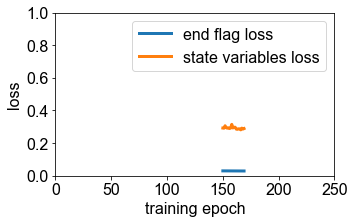

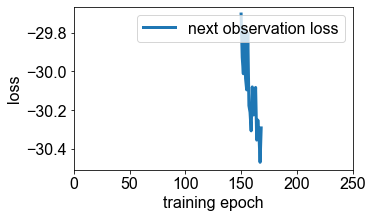

In [16]:
losses_store = np.load(f'data/rnn{rnn_id}/rnn_losses.npz')['losses_store']

plt.rcParams.update({'font.family': 'Arial', 'font.size': 16})
plt.figure(figsize=(5, 3))  # Adjust the figure size as needed
plt.plot(np.mean(losses_store, axis=1)[:, 1], linewidth=3, label="end flag loss")
plt.plot(np.mean(losses_store, axis=1)[:, 2], linewidth=3, label="state variables loss")
plt.ylim(0, 1)
plt.xlim(0, 250)
plt.legend()
plt.xlabel("training epoch")
plt.ylabel("loss")
plt.show()

plt.figure(figsize=(5, 3))  # Adjust the figure size as needed
plt.plot(np.mean(losses_store, axis=1)[:, 0], linewidth=3, label="next observation loss")
plt.legend()
plt.xlim(0, 250)
plt.xlabel("training epoch")
plt.ylabel("loss")
plt.show()

In [17]:
vae_model = vae.VAE(latent_dim=dim_latent_z).to(config.device)
vae_model.load_state_dict(torch.load(f"data/vae_model_{dim_latent_z}dimlatent.pt", map_location=config.device))

epoch = 250
rnn_model = rnn.MDNRNN(dim_latent_z, state_vars_to_predict=state_vars_to_predict, use_layernorm=use_layernorm).to(config.device)
rnn_model.load_state_dict(torch.load(f'data/rnn{rnn_id}/rnn_model_epoch{epoch}.pt', map_location=config.device))
n_gaussians = rnn_model.n_gaussians

FileNotFoundError: [Errno 2] No such file or directory: 'data/rnn_ln1_nh128_dlz8_mgn100.0_lr0.001_dg0_da40_sv9x10x11_lsv40.0_r22/rnn_model_epoch250.pt'

In [ ]:
batch_size = 256
n_batches, mean_batches, var_batches, state_vars_batches, \
    action_batches, mask_batches, end_flag_batches = \
    train_rnn.load_data(f'data/vae_preprocessed_{dim_latent_z}dimlatent.npz', 
                                        f'data/vae_rollouts_env_vars.npz', batch_size = batch_size,
                       truncate_at_batch=truncate_at_batch)
episode_len = ([torch.nonzero(end_flags)[:, 1] for end_flags in end_flag_batches])
#var_batches = [torch.log(var_batch) for var_batch in var_batches]

In [ ]:
length_cutoff = 301  # Specify the desired length cutoff

filtered_episodes = []

for i in range(len(episode_len)):
    for j in range(len(episode_len[i])):
        if episode_len[i][j] >= length_cutoff:
            episode_data = {
                'mean': mean_batches[i][j, :length_cutoff, :],
                'var': var_batches[i][j, :length_cutoff, :],
                'state_vars': state_vars_batches[i][j, :length_cutoff, :],
                'action': action_batches[i][j, :length_cutoff, :],
                'mask': mask_batches[i][j, :length_cutoff],
                'end_flag': end_flag_batches[i][j, :length_cutoff, :],
            }
            filtered_episodes.append(episode_data)

# Convert the filtered episodes to tensors
filtered_episodes_tensor = {
    'mean': torch.stack([ep['mean'] for ep in filtered_episodes]),
    'var': torch.stack([ep['var'] for ep in filtered_episodes]),
    'state_vars': torch.stack([ep['state_vars'] for ep in filtered_episodes]),
    'action': torch.stack([ep['action'] for ep in filtered_episodes]),
    'mask': torch.stack([ep['mask'] for ep in filtered_episodes]),
    'end_flag': torch.stack([ep['end_flag'] for ep in filtered_episodes])
} # shape of every tensor: [n_episodes, batch_size, dim_latent_z]
n_episodes = filtered_episodes_tensor['mean'].shape[0]
batch_size = n_episodes

In [ ]:
def record_predictions(cutoff_t=None):
    """
        Runs the RNN over the selected episodes
        (optionally detaching from the environment at t=cutoff_t, 
        and continuing with the outputted Z values put back in).
        Returns the following:
        z_pred_store: (every entry is (pi, mu, sigma); each is [batch_size, 1, n_gaussians, :])
        ef_store: tensor of size [batch_size, n_timesteps, 1]
        y_store: tensor of size [batch_size, n_timesteps, RNN_hidden_dim]
    """
    means = filtered_episodes_tensor['mean']
    vars = filtered_episodes_tensor['var']
    actions = filtered_episodes_tensor['action']
    masks = filtered_episodes_tensor['mask'][:, 1:]
    state_vars = filtered_episodes_tensor['state_vars'][:, :-1]
    z_values = train_vae.reparameterization(means, vars)
    inputs = torch.cat([z_values, actions], dim=2)[:, :-1] #(batch_size, n_timesteps, dim_latent_z+1)
    n_timesteps = inputs.shape[1]
    if cutoff_t is None: cutoff_t = n_timesteps
    
    z_pred_store = [] # every entry is (pi, mu, sigma); each is [batch_size, 1, n_gaussians, :]
    ef_store = [] # each entry is [batch_size, 1, 1]
    y_store = [] # each entry is [batch_size, 1, 1]
    with torch.no_grad():
        hidden = rnn_model.init_hidden(batch_size)
        for t in range(n_timesteps):
            if t < cutoff_t:
                # sample true input from environment
                inputs_t = inputs[:, t:t+1, :]
            else:
                # sample input from previous output of RNN
                pi, mu, sigma = z_pred_store[-1]
                sampled_indices = torch.multinomial(pi[:, :, :].reshape(-1, n_gaussians), 1).reshape(batch_size, 1, 1, 1).repeat(1, 1, 1, dim_latent_z)
                mu_sampled = torch.gather(mu, 2, sampled_indices)
                sigma_sampled = torch.gather(sigma, 2, sampled_indices)
                z_sampled = train_vae.reparameterization(mu_sampled, sigma_sampled).reshape(batch_size, 1, dim_latent_z)
                inputs_t = torch.cat([z_sampled, actions[:, t:t+1, :]], dim=2)
                
            # run RNN on this input and record result
            (pi, mu, sigma), ef, hidden, y = rnn_model(inputs_t, hidden)
            z_pred_store.append((pi, mu, sigma))
            ef_store.append(ef)
            y_store.append(y)
    return z_pred_store, torch.cat(ef_store, dim=1), torch.cat(y_store, dim=1)

In [18]:
means = filtered_episodes_tensor['mean']
vars = filtered_episodes_tensor['var']
actions = filtered_episodes_tensor['action']
masks = filtered_episodes_tensor['mask'][:, 1:]
state_vars = filtered_episodes_tensor['state_vars'][:, :-1]
z_values = train_vae.reparameterization(means, vars)
inputs = torch.cat([z_values, actions], dim=2)[:, :-1]

In [19]:
def make_images(z_pred_store, episode_i):
    means = filtered_episodes_tensor['mean']
    vars = filtered_episodes_tensor['var']
    actions = filtered_episodes_tensor['action']
    masks = filtered_episodes_tensor['mask'][:, 1:]
    state_vars = filtered_episodes_tensor['state_vars'][:, :-1]
    z_values = train_vae.reparameterization(means, vars)
    inputs = torch.cat([z_values, actions], dim=2)[:, :-1]
    n_timesteps = inputs.shape[1]

    z_sampled_store = []
    for t in range(n_timesteps):
        # sample input from previous output of RNN
        pi, mu, sigma = z_pred_store[t]
        sampled_indices = torch.multinomial(pi[:, :, :].reshape(-1, n_gaussians), 1).reshape(batch_size, 1, 1, 1).repeat(1, 1, 1, dim_latent_z)
        mu_sampled = torch.gather(mu, 2, sampled_indices)
        sigma_sampled = torch.gather(sigma, 2, sampled_indices)
        z_sampled = train_vae.reparameterization(mu_sampled, sigma_sampled).reshape(batch_size, 1, dim_latent_z)
        z_sampled_store.append(z_sampled)

    z_sampled = torch.cat(z_sampled_store, dim=1)
    img_rec = vae_model.decode(z_sampled)[episode_i].cpu().detach().numpy()
    img_real = vae_model.decode(z_values[:, 1:])[episode_i].cpu().detach().numpy()
    return img_rec, img_real

In [20]:
cutoff_t = 50
z_pred_store, ef_store, y_store = record_predictions(cutoff_t=cutoff_t)

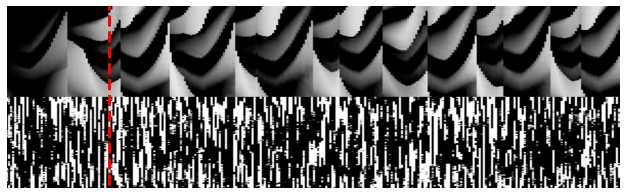

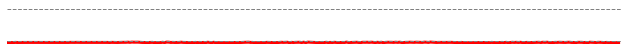

In [21]:
episode_i = 30
max_show_timestep = 300

img_rec, img_real = make_images(z_pred_store, episode_i)
img = np.concatenate([img_real[:max_show_timestep].T, img_rec[:max_show_timestep].T])
# Display the barcode tensor as an image using Matplotlib
plt.figure(figsize=(9, 3))  # Adjust the figure size as needed
plt.imshow(img, cmap='binary', aspect='auto')
if cutoff_t is not None:
    plt.plot([cutoff_t, cutoff_t], [-1000, 1000], "r--", linewidth=3)
plt.axis('off')
plt.ylim(360, 0)
plt.xlim(0, max_show_timestep)
plt.tight_layout()
plt.show()
# show end flag over time
plt.figure(figsize=(9, 1))
plt.plot(ef_store[episode_i, :max_show_timestep].reshape(-1).detach().cpu().numpy(),
        "-", color="red", linewidth=3)
plt.plot([0, max_show_timestep], [0, 0], "--", color="gray", linewidth=1)
plt.plot([0, max_show_timestep], [1, 1], "--", color="gray", linewidth=1)
plt.ylim(-.1, 1.1)
plt.xlim(0, max_show_timestep)
plt.axis('off')
plt.tight_layout()
plt.show()

# Training linear probes

In [337]:
cutoff_t = None
z_pred_store, ef_store, y_store = record_predictions(cutoff_t=cutoff_t)

In [328]:
means = filtered_episodes_tensor['mean']
vars = filtered_episodes_tensor['var']
actions = filtered_episodes_tensor['action']
masks = filtered_episodes_tensor['mask'][:, 1:]
state_vars = filtered_episodes_tensor['state_vars'][:, :-1]
z_values = train_vae.reparameterization(means, vars)

In [334]:
cutoff_t = 75
z_pred_store, ef_store, y_store = record_predictions(cutoff_t=cutoff_t)

In [348]:
z_pred_store[0][0].shape

torch.Size([562, 1, 5])

In [340]:
import torch
import scipy.linalg as linalg
import numpy as np

# Assuming you have the following variables:
# state_vars: tensor of shape [batch_size, n_timesteps, 12]
# y_store: tensor of shape [batch_size, n_timesteps, hidden_dim]

# Get the dimensions
batch_size, n_timesteps, n_state_vars = state_vars.shape
_, _, hidden_dim = y_store.shape

# Create a list to store the best linear decoders for each state variable
best_decoders = []

# Iterate over each state variable
for i in range(n_state_vars):
    # Reshape y_store and state_vars for the current state variable
    # Starting decoding from 100 timesteps to avoid incorporating starting values (some of which are set arbitrary)
    X = y_store[:, 100:, :].reshape(-1, hidden_dim).numpy()
    y = state_vars[:, 100:, i].reshape(-1, 1).numpy()

    # Add a row of 1s to X for bias
    X_with_bias = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)

    # Find the best linear decoder using least squares
    decoder_weights, _, _, _ = linalg.lstsq(X_with_bias, y)

    # Create a linear decoder with the obtained weights and bias
    decoder = torch.nn.Linear(hidden_dim, 1, bias=True)
    decoder.weight.data = torch.tensor(decoder_weights[:-1], dtype=torch.float32).reshape(1, -1)
    decoder.bias.data = torch.tensor(decoder_weights[-1], dtype=torch.float32)

    # Append the decoder to the list
    best_decoders.append(decoder)

In [341]:
def show_sv_curves(sv_i, episode_i):
    decoder = best_decoders[sv_i]
    
    sv = state_vars[episode_i, :max_show_timestep, sv_i]
    sv_pred = decoder(y_store[episode_i, :max_show_timestep, :]).detach().numpy()
    
    print(config.state_variables_names[sv_i])
    plt.figure(figsize=(9, 2))
    plt.plot(sv, "-", color="black", linewidth=3)
    #plt.plot(sv_pred-np.mean(sv_pred), "-", color="red", linewidth=3)
    plt.plot(sv_pred, "-", color="red", linewidth=3)
    plt.plot([0, max_show_timestep], [0, 0], "--", color="gray", linewidth=1)
    plt.plot([0, max_show_timestep], [1, 1], "--", color="gray", linewidth=1)
    #plt.ylim(-.1, 1.1)
    plt.xlim(0, max_show_timestep)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

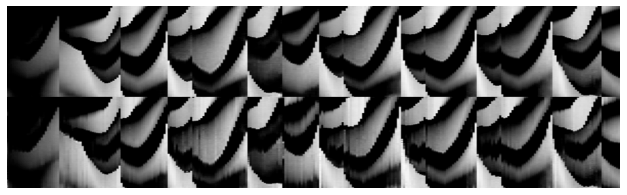

episode end flag


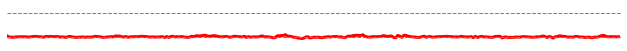

player's vertical position


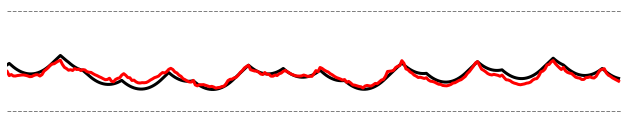

In [343]:
episode_i = 20
max_show_timestep = 300

img_rec, img_real = make_images(z_pred_store, episode_i)
img = np.concatenate([img_real[:max_show_timestep].T, img_rec[:max_show_timestep].T])
# Display the barcode tensor as an image using Matplotlib
plt.figure(figsize=(9, 3))  # Adjust the figure size as needed
plt.imshow(img, cmap='binary', aspect='auto')
if cutoff_t is not None:
    plt.plot([cutoff_t, cutoff_t], [-1000, 1000], "r--", linewidth=3)
plt.axis('off')
plt.ylim(360, 0)
plt.xlim(0, max_show_timestep)
plt.tight_layout()
plt.show()

# show end flag over time
print("episode end flag")
plt.figure(figsize=(9, 1))
plt.plot(ef_store[episode_i, :max_show_timestep].reshape(-1).detach().cpu().numpy(),
        "-", color="red", linewidth=3)
plt.plot([0, max_show_timestep], [0, 0], "--", color="gray", linewidth=1)
plt.plot([0, max_show_timestep], [1, 1], "--", color="gray", linewidth=1)
plt.ylim(-.3, 1.3)
plt.xlim(0, max_show_timestep)
plt.axis('off')
plt.tight_layout()
plt.show()

################################

for i in [9]:
    show_sv_curves(i, episode_i)

# Calculating drift

In [120]:
means = filtered_episodes_tensor['mean']
vars = filtered_episodes_tensor['var']
actions = filtered_episodes_tensor['action']
masks = filtered_episodes_tensor['mask'][:, 1:]
state_vars = filtered_episodes_tensor['state_vars'][:, :-1]
z_values = train_vae.reparameterization(means, vars)

In [121]:
cutoff_t_range = range(100,200, 10)

In [122]:
z_pred_stores = []
for cutoff_t in cutoff_t_range:
    z_pred_store, ef_store, y_store = record_predictions(cutoff_t=cutoff_t)
    z_pred_stores.append(z_pred_store)
    print(cutoff_t, end=" ")

100 110 120 130 140 150 160 170 180 190 

In [126]:
ts_after_cutoff = [-1]#[-1, 0, 1, 2, 3, 4, 5]
for t_after_cutoff in ts_after_cutoff:
    print(t_after_cutoff, end=" ")
    
    gmm_real_pis = []
    gmm_real_means = []
    gmm_real_vars = []
    gmm_rec_pis = []
    gmm_rec_means = []
    gmm_rec_vars = []
    for cutoff_t_i, cutoff_t in enumerate(cutoff_t_range):
        for episode_i in range(n_episodes):
            gmm_real_pis.append(1)
            gmm_real_means.append(means[episode_i, cutoff_t+t_after_cutoff])
            gmm_real_vars.append(vars[episode_i, cutoff_t+t_after_cutoff])

        # every entry of z_pred_stores[cutoff_t_i] is (pi, mu, sigma); each is [batch_size, 1, n_gaussians, :]
        pi, mu, sigma = z_pred_stores[cutoff_t_i][cutoff_t+t_after_cutoff]
        n_gaussians = pi.shape[2]
        for episode_i in range(n_episodes):
            for gaussian_i in range(n_gaussians):
                gmm_rec_pis.append(pi[episode_i, 0, gaussian_i])
                gmm_rec_means.append(mu[episode_i, 0, gaussian_i])
                gmm_rec_vars.append(sigma[episode_i, 0, gaussian_i])

    n_components, n_features = len(gmm_real_pis), len(gmm_real_means[0])
    gmm_real = GaussianMixture(n_components=n_components, covariance_type='diag')
    gmm_real.weights_ = (torch.tensor(gmm_real_pis)/torch.tensor(gmm_real_pis).sum()).numpy()
    gmm_real.means_ = torch.stack(gmm_real_means).numpy()
    gmm_real.covariances_ = torch.stack(gmm_real_vars).numpy()**2
    n_components, n_features = len(gmm_rec_pis), len(gmm_rec_means[0])
    gmm_rec = GaussianMixture(n_components=n_components, covariance_type='diag')
    gmm_rec.weights_ = (torch.tensor(gmm_rec_pis)/torch.tensor(gmm_real_pis).sum()).numpy()
    gmm_rec.means_ = torch.stack(gmm_rec_means).numpy()
    gmm_rec.covariances_ = torch.stack(gmm_rec_vars).numpy()**2
    print("GMMs created; ")
    break
    print()

-1 GMMs created; 


In [124]:
import numpy as np
from scipy.stats import multivariate_normal

def kl_divergence_gmm(gmm_p, gmm_q, n_samples=10000):
    """
    Compute KL divergence between two GMMs P and Q using monte carlo approximation.
    
    Args:
        gmm_p (tuple): GMM P represented as (weights, means, covariances)
        gmm_q (tuple): GMM Q represented as (weights, means, covariances)
        n_samples (int): Number of samples to use for monte carlo approximation
        
    Returns:
        float: KL divergence D(P || Q)
    """
    # Unpack GMM parameters
    pi_p, mu_p, var_p = gmm_p
    pi_q, mu_q, var_q = gmm_q
    
    # Sample from GMM P
    samples = sample_from_gmm(pi_p, mu_p, var_p, n_samples)
    
    # Compute log probabilities of samples under each GMM
    log_p = log_likelihood_gmm(pi_p, mu_p, var_p, samples)
    log_q = log_likelihood_gmm(pi_q, mu_q, var_q, samples)
    
    # Compute monte carlo approximation of KL divergence
    kl_div = np.mean(log_p - log_q)
    
    return kl_div

def sample_from_gmm(weights, means, covars, n_samples):
    """Sample from a GMM."""
    n_components = len(weights)
    samples = np.zeros((n_samples, means[0].shape[0]))
    
    # Sample component indices according to weights
    comp_indices = np.random.choice(range(n_components), size=n_samples, p=weights)
    
    # Sample from each component
    for i in range(n_components):
        n_samples_i = np.sum(comp_indices == i)
        samples[comp_indices == i, :] = np.random.multivariate_normal(
            means[i], np.diag(covars[i]), size=n_samples_i
        )
        
    return samples

def log_likelihood_gmm(weights, means, covars, samples):
    """Compute log likelihood of samples under a GMM."""
    n_components = len(weights)
    log_lh = np.zeros(samples.shape[0])
    
    for i in range(n_components):
        log_lh += weights[i] * multivariate_normal.pdf(samples, mean=means[i], cov=np.diag(covars[i]), allow_singular=True)
        
    return np.log(log_lh)

## 9x10x11
t=0

KL divergence: 21.376

KL divergence: 21.496

t=1

KL divergence: 23.178

t=5

KL divergence: 26.206

## X

t=-1
KL divergence: 23.504

t=0

KL divergence: 25.873

t=5

KL divergence: 29.796


In [127]:
gmm_real = ((torch.tensor(gmm_real_pis)/torch.tensor(gmm_real_pis).sum()).numpy(), 
            torch.stack(gmm_real_means).numpy(), torch.stack(gmm_real_vars).numpy()**2) 
gmm_rec = ((torch.tensor(gmm_rec_pis)/torch.tensor(gmm_rec_pis).sum()).numpy(), 
            torch.stack(gmm_rec_means).numpy(), torch.stack(gmm_rec_vars).numpy()**2) 

kl_div = kl_divergence_gmm(gmm_real, gmm_rec)
print(f"KL divergence: {kl_div:.3f}")

KL divergence: 32.400


# Archive

In [145]:
def get_losses(rnn_model):
    batch_size = mean_batches[0].shape[0]
    hidden_batches = []
    for batch_i in range(n_batches):
        hidden = rnn_model.init_hidden(batch_size)
    
        means = mean_batches[batch_i]
        vars = var_batches[batch_i]
        actions = action_batches[batch_i]
        masks = mask_batches[batch_i][:, 1:]
        end_flags = end_flag_batches[batch_i]
        state_vars = state_vars_batches[batch_i][:, :-1]
        z_values = train_vae.reparameterization(means, vars)
        inputs = torch.cat([z_values[:, :-1], actions[:, :-1]], dim=2)  # [:, :-1]
        
        # hidden = detach(hidden)
        (pi, mu, sigma), ef, hidden, y = rnn_model(inputs, hidden)
        hidden_batches.append(y.detach())
    
    linear_model = torch.nn.Linear(hidden_batches[0].shape[2], state_vars_batches[0].shape[2])
    optimizer = torch.optim.Adam(linear_model.parameters())#, lr=0.001)
    
    n_epochs = 50
    for epoch in range(n_epochs):
        # Set initial hidden and cell states
        for batch_i in range(n_batches):
            masks = mask_batches[batch_i][:, 1:]
            state_vars = state_vars_batches[batch_i][:, :-1]
            hidden_states = hidden_batches[batch_i][:, :]
    
            state_vars_pred = linear_model(hidden_states)
            loss = torch.mean((state_vars_pred - state_vars)**2 * masks.unsqueeze(2))
    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            #if (epoch + 1) % 10 == 0: print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}")
    
    loss = 0
    loss_denom = 0
    with torch.no_grad():
        for batch_i in range(n_batches):
            masks = mask_batches[batch_i][:, 1:]
            state_vars = state_vars_batches[batch_i][:, :-1]
            hidden_states = hidden_batches[batch_i][:, :]
    
            state_vars_pred = linear_model(hidden_states)
            loss += torch.sum((state_vars_pred - state_vars)**2 * masks.unsqueeze(2), dim=[0,1])
            loss_denom += torch.sum(masks).item()
    return loss / loss_denom

In [146]:
rnn_epochs = [50, 100, 200, 300, 400, 500]
losses_stores = []
for rnn_epoch in rnn_epochs:
    rnn_model = rnn.MDNRNN(dim_latent_z, state_vars_to_predict=state_vars_to_predict).to(config.device)
    rnn_model.load_state_dict(torch.load(f'data/rnn{rnn_id}/rnn_model_epoch{rnn_epoch}.pt', map_location=config.device))
    print(rnn_epoch)
    losses_stores.append(get_losses(rnn_model))

50
100
200
300
400
500


In [40]:
state_variables_names =  [
    "the last pipe's horizontal position",
    "the last top pipe's vertical position",
    "the last bottom pipe's vertical position",
    "the next pipe's horizontal position",
    "the next top pipe's vertical position",
    "the next bottom pipe's vertical position",
    "the next next pipe's horizontal position",
    "the next next top pipe's vertical position",
    "the next next bottom pipe's vertical position",
    "player's vertical position",
    "player's vertical velocity",
    "player's rotation",
]

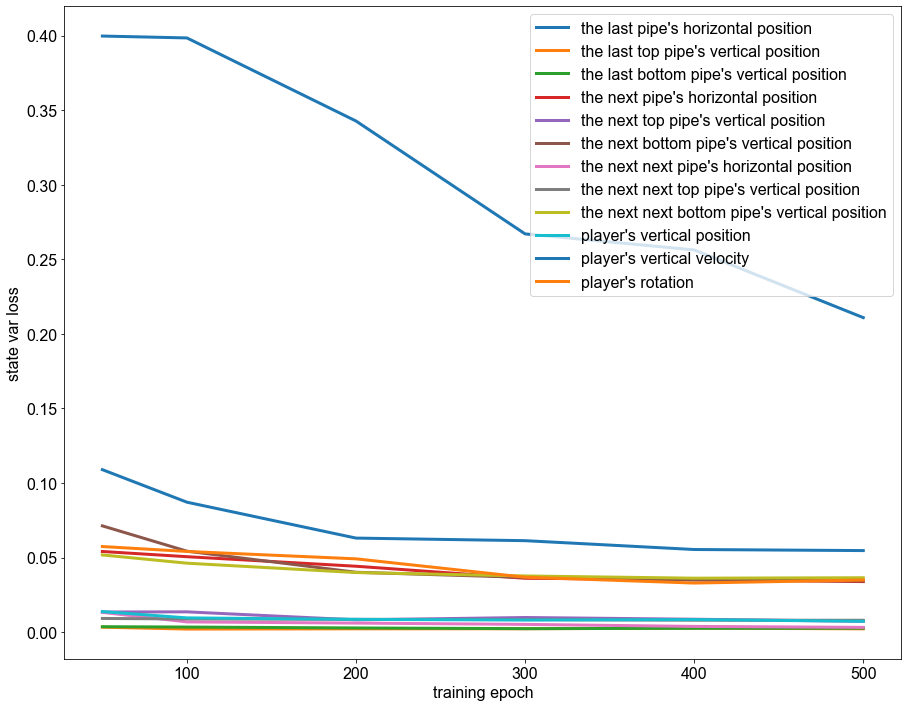

In [148]:
plt.rcParams.update({'font.family': 'Arial', 'font.size': 16})
plt.figure(figsize=(15, 12))  # Adjust the figure size as needed
for i, name in enumerate(state_variables_names):
    plt.plot(rnn_epochs, [losses_store[i] for losses_store in losses_stores], linewidth=3, label=state_variables_names[i])
plt.legend()
plt.xlabel("training epoch")
plt.ylabel("state var loss")
plt.show()

In [37]:
batch_i = 0
masks = mask_batches[batch_i][:, 1:]
state_vars = state_vars_batches[batch_i][:, :-1]
hidden_states = hidden_batches[batch_i][:, :]

state_vars_pred = linear_model(hidden_states)

In [38]:
state_vars[0, :, -1].shape

torch.Size([513])